In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import os

os.chdir("C:/Users/kaborg15/PycharmProjects/FREja_API/")
CLIP_DATA_PATH = r"resources/clip_vectors"
#LOAD_VECTOR_HASH = "9d8b31fd16d4edb8c7333a9e6048c5f3623ef9d7_0146843e927994c24f8320c41bc155100c3624b2cd7fcc914b883ac9483f3d4f"
LOAD_VECTOR_HASH = "ead6cba5fe7ab8c333b5a3ae4d420f253deab0f9_fee8adfde65c4ffdfeed7aa44945f18f5892c2b556a1c51f2eb257a94267d14b"

import pandas as pd
import numpy as np
load_data_path = os.path.join(CLIP_DATA_PATH, LOAD_VECTOR_HASH)

fclip_image_vectors = np.load(os.path.join(load_data_path, "fclip_image_vectors.npy"))
fclip_text_vectors = np.load(os.path.join(load_data_path, "fclip_text_vectors.npy"))
pictures_df = pd.read_pickle(os.path.join(load_data_path, "pictures_df.pkl"))
outfits_df = pd.read_pickle(os.path.join(load_data_path, "outfits_df.pkl"))

def merge_in_outfit_columns(outfit_df, pictures_df, column_names):
    outfit_df_subset = outfit_df[["id"] + column_names]
    outfit_df_subset.columns = ["owner"] + column_names
    pictures_df = pictures_df.merge(outfit_df_subset, on="owner", how="left")
    return pictures_df

pictures_df["image_embedding"] = list(fclip_image_vectors)
pictures_df["text_embedding"] = list(fclip_text_vectors)
pictures_df = pictures_df.drop(columns=["keep_row"], errors="ignore")
embeddings_df = merge_in_outfit_columns(outfits_df, pictures_df, ["name", "description", "outfit_tags",	"tag_categories",	"Outfit_size",	"tag_encoding",	"description"])

In [2]:
from FREja_API.retrieve_db_data import construct_orders_df
from resources.database_interactor import get_db_query
from FREja_API.constants import *

USERS_KEEP_COLUMNS = ["id", "username", "email"]
users_df = get_db_query(USER_QUERY)
orders_df = construct_orders_df()
orders_df = orders_df.merge(users_df[USERS_KEEP_COLUMNS].copy(), left_on="customer.id", right_on="id", how="left")
orders_df = orders_df.rename(columns={"id_x": "id", "id_y": "user_id"})
orders_df.head(2)

,id,customer.id,extras.contactEmail,meta.validFrom,derived.bookingTime,shoppingCartMarker,subscription_id,order,subscription,outfit.id,user_id,username,email
0,Orders.000045e1e297435fa873dcafe17ce84c,user.5370d455f3fa48e387f3cf48bd40dc7f,stine.rastad@gmail.com,2023-04-27 12:46:35.184,2023-03-19 14:24:09.539,None,SubscriptionRentals.427419d5834d4f1283df9c3a62...,Orders.000045e1e297435fa873dcafe17ce84c,SubscriptionPurchases.c054d06185bd45da83abb53f...,outfit.5c081909537b42239e465d2d615c705f,user.5370d455f3fa48e387f3cf48bd40dc7f,None,stine.rastad@gmail.com
1,Orders.0001f72e4202449e935b32757b851419,user.d1ca50e54c4c47ffbeef35a0c9b16b29,kristin_hoel@hotmail.com,2023-05-05 09:44:38.200,2023-01-17 13:36:53.371,None,SubscriptionRentals.131c173b125a43a4ae02bf33f4...,Orders.0001f72e4202449e935b32757b851419,SubscriptionPurchases.0f93ee44b6b24d07aec1d941...,outfit.c34969dd8b334064aa90bfb60c8ec308,user.d1ca50e54c4c47ffbeef35a0c9b16b29,None,kristin_hoel@hotmail.com


Initializing FJONG bucket...


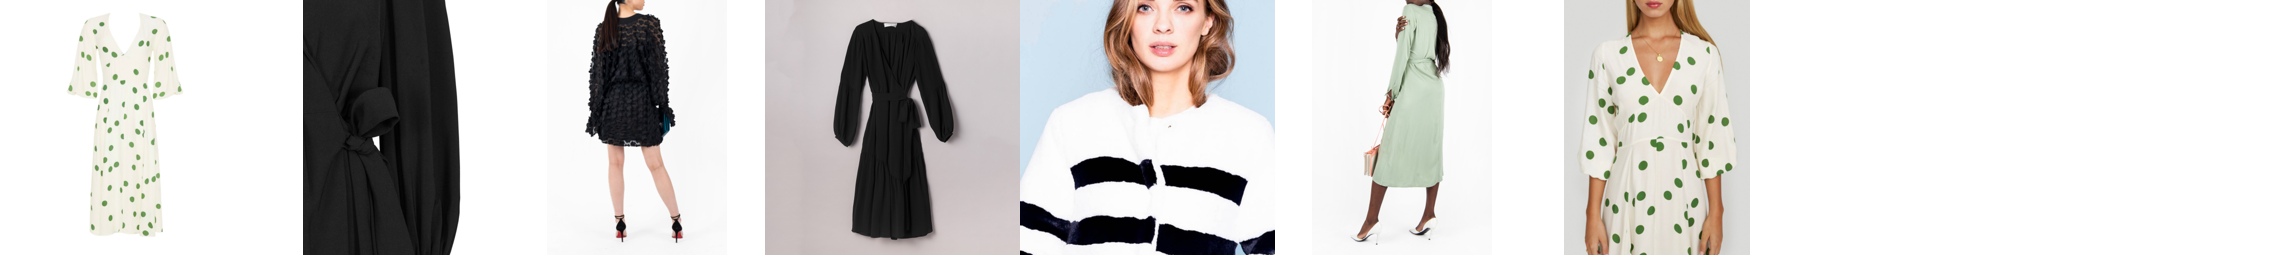

In [3]:
import random

def get_user_outfits(min_outfits=1, random_state=33):
    print(f"Random state: {random_state}")
    users = orders_df["customer.id"].value_counts()[orders_df["customer.id"].value_counts() > min_outfits]
    arb_user = users.sample(1, random_state=random_state).index[0]
    user_orders = orders_df[orders_df["customer.id"] == arb_user]
    user_outfit_ids = user_orders["outfit.id"]
    user_outfits = embeddings_df[embeddings_df["owner"].isin(user_outfit_ids)].groupby("owner").first().reset_index()
    return user_outfits

import sys
sys.path.append("C:/Users/kaborg15/PycharmProjects/fashion-clip")

from fashion_clip.fashion_clip import display_images
from fashion_clip.load_images_from_FJONG import retrieve_picture_ids, get_bucket, download_picture

class ImageDisplay:
    def __init__(self):
        self.bucket = None

    def display_images_from_fjong(self, image_ids, **kwargs):
        if self.bucket is None:
            print("Initializing FJONG bucket...")
            self.bucket = get_bucket()
        image_paths = []
        #print(f"printing image paths: {image_ids}")
        for img_id in image_ids:
            img_id = img_id.split(os.path.sep)[-1]
            download_path = f"resources/fjong_images/{img_id}"
            if not os.path.isfile(download_path):
                download_picture(self.bucket, img_id, save_file_name=download_path)
            image_paths.append(download_path)
        return display_images(image_paths, columns=9, max_images=27, plot_figure=False, **kwargs)

    def format_collage(self, image_ids):
        collage = self.display_images_from_fjong(image_ids)
        collage.thumbnail((1500, 800), Image.LANCZOS)
        return collage

def display_arb_user_purchases(user_seeds):
    image_display = ImageDisplay()
    users = orders_df["customer.id"].value_counts()[orders_df["customer.id"].value_counts() > 5]

    for seed in user_seeds:
        arb_user = users.sample(1, random_state=seed).index[0]
        user_orders = orders_df[orders_df["customer.id"] == arb_user]
        user_outfit_ids = user_orders["outfit.id"]
        user_outfits = embeddings_df[embeddings_df["owner"].isin(user_outfit_ids)].groupby("owner").first()
        display(image_display.display_images_from_fjong(user_outfits["id"].values))

display_arb_user_purchases(list(range(1)))

In [29]:
from FREja_API.retrieve_db_data import construct_train_test_df

invalid_user_outfits = 0

user_validation_data = construct_train_test_df(orders_df, embeddings_df)
print(user_validation_data.shape)
user_validation_data.head(20)

(1458, 7)


,customer.id,email,username,backlog_length,unique_outfits,input_outfits,label_outfit
0,user.0002cc107c3743edafbe60d16b715a55,anne.s.svalastog@gmail.com,None,27,27,"[outfit.c1d7d92e8d604a2e85b9eceecc630405, outf...",outfit.3d315786a48541219d62027750941507
1,user.006753f5f62e4fdab069526e611ef487,Marte.kopstad@gmail.com,None,45,45,"[outfit.1dcf89de27284ebe9851d5fcd42e9fa1, outf...",outfit.df36aeab8ee742388c43c6b8f832f4be
2,user.00a6b9163bbe4f0d962a7f3a277dc148,aurora_8008@hotmail.com,None,9,9,"[outfit.78272e5994da4658ac56ede658533a78, outf...",outfit.54006e2da4dc4c0195af9858f7288df2
3,user.00b8fed52c8141af9bc06ecc454c42d7,Hege_se@hotmail.com,None,7,7,"[outfit.ef1d5562f0b64f8ebef2f04c475d398e, outf...",outfit.ae538ccb6bf14a858b0f66458e592872
4,user.00be36a4fbb5473aa9a17291d634d5d4,turi.pettersen@gmail.com,None,37,37,"[outfit.269136713d7d4d58afd15f74be35207d, outf...",outfit.c47ac45c182049df8636c0e8572076c1
5,user.00c7a3e8d1ab485ab49f7f8089dcd8e7,victoria_st_11@hotmail.com,None,13,13,"[outfit.878bc93711f64443856d8ade973b34b6, outf...",outfit.3e574204b0124cc3a30a7800b58359f2
6,user.00c8e3cfd7ec42a6a6c17b504af18892,karoline.oien@gmail.com,None,33,31,"[outfit.a6b9c3792d6a4ad4, outfit.9936eee8f01a2...",outfit.bcd6c34a7560487394fd7bb9d514f798
8,user.00e6e9543da24ca1b756f02b678b67b5,marianneliaklev@hotmail.com,None,22,21,"[outfit.499d31bd36254c7191245e1d40745824, outf...",outfit.66d3312bdc374034938b725a9131d6be
9,user.00fa37cf5efa471ba1a745611797cc3d,flaatensandra@gmail.com,None,9,9,"[outfit.0ff7ccec21ac4dedab44d06b576a99e6, outf...",outfit.e2b66b5d631840f2902ce6125a60b9fe
10,user.0163ea88f19546ecaf5ed76359fde464,millymoen@hotmail.com,None,13,13,"[outfit.8b84cac630124f089c22f0ae7b56b07d, outf...",outfit.af3a5e4cc2959d66


In [35]:
user_triplets = user_validation_data.explode("input_outfits")[["customer.id", "input_outfits"]].rename({"input_outfits": "outfit"}, axis=1).copy()
user_triplets = (
    user_triplets.groupby(["customer.id", "outfit"])
    .size()
    .reset_index(name='count')
)
user_triplets

,customer.id,outfit,count
0,user.0002cc107c3743edafbe60d16b715a55,outfit.26e0f5cc69634d079b4cd4a55b315809,1
1,user.0002cc107c3743edafbe60d16b715a55,outfit.3984754756394c3e95ade4b2080508c6,1
2,user.0002cc107c3743edafbe60d16b715a55,outfit.3cb6317f7e7b435a99c48854f7019faf,1
3,user.0002cc107c3743edafbe60d16b715a55,outfit.4e6f97c4451043f5bebd6ac8235f8a8f,1
4,user.0002cc107c3743edafbe60d16b715a55,outfit.5c37bcc491cc480f9baa04f54f7055cb,1
...,...,...,...
47712,user.ffdf33e688af413e84d26404e00edadc,outfit.15653a6712be4dac88726c5e9fa449ff,1
47713,user.ffdf33e688af413e84d26404e00edadc,outfit.53a0c9e1c47d442dbdcfb14c54769e08,1
47714,user.ffdf33e688af413e84d26404e00edadc,outfit.87cafc24da73f5a4,1
47715,user.ffdf33e688af413e84d26404e00edadc,outfit.c94d85f7dfd84281b556d38b2303cf21,1


In [36]:
from scipy import sparse

user_triplets = user_triplets.pivot(index="customer.id", columns="outfit", values="count").fillna(0)
interactions_matrix = sparse.csr_matrix(user_triplets.values)
interactions_matrix


<1458x10152 sparse matrix of type '<class 'numpy.float64'>'
	with 47717 stored elements in Compressed Sparse Row format>

In [ ]:
import json

class Params:
    """
    Class that loads hyper-parameters from a json file.
    Example:
    ```
    params = Params(json_path)
    print(params.learning_rate)
    params.learning_rate = 0.5  # change the value of learning_rate in params
    ```
    """

    def __init__(self, json_path):
        self.path = json_path
        with open(json_path) as f:
            params = json.load(f)
            self.__dict__.update(params)

    def save(self, json_path):
        with open(json_path, 'w') as f:
            json.dump(self.__dict__, f, indent=4)

    def update(self, json_path):
        """Loads parameters from json file"""
        with open(json_path) as f:
            params = json.load(f)
            self.__dict__.update(params)

    def __str__(self):
        # return string representation of 'Parameters' class
        ret = '======== [Config] ========\n'
        for k in self.__dict__:
            ret += '%s: %s\n' % (str(k), str(self.__dict__[k]))
        ret += '\n'
        return ret

    @property
    def dict(self):
        """
        Gives dict-like access to params instance by
        `params.dict['learning_rate']
        """
        return self.__dict__

    def update_dict(self, k, v):
        self.__dict__[k] = v

In [39]:
from torch import nn
import torch.nn.functional as F
import torch

class BaseModel(nn.Module):
    """
    Base model class
    """
    def __init__(self):
        super(BaseModel, self).__init__()

    def forward(self, *input):
        pass

    def train_one_epoch(self, *input):
        pass

    def predict(self, eval_users, eval_pos, test_batch_size):
        pass

class MultVAE(BaseModel):
    """
    Variational Autoencoder with Multninomial Likelihood model class
    """
    def __init__(self, model_conf, num_users, num_items, device):
        """
        :param model_conf: model configuration
        :param num_users: number of users
        :param num_items: number of items
        :param device: choice of device
        """
        super(MultVAE, self).__init__()
        self.num_users = num_users
        self.num_items = num_items

        self.enc_dims = [self.num_items] + model_conf.enc_dims
        self.dec_dims = self.enc_dims[::-1]
        self.dims = self.enc_dims + self.dec_dims[1:]

        self.total_anneal_steps = model_conf.total_anneal_steps
        self.anneal_cap = model_conf.anneal_cap

        self.dropout = model_conf.dropout

        self.eps = 1e-6
        self.anneal = 0.
        self.update_count = 0

        self.device = device

        self.encoder = nn.ModuleList()
        for i, (d_in, d_out) in enumerate(zip(self.enc_dims[:-1], self.enc_dims[1:])):
            if i == len(self.enc_dims[:-1]) - 1:
                d_out *= 2
            self.encoder.append(nn.Linear(d_in, d_out))
            if i != len(self.enc_dims[:-1]) - 1:
                self.encoder.append(nn.Tanh())

        self.decoder = nn.ModuleList()
        for i, (d_in, d_out) in enumerate(zip(self.dec_dims[:-1], self.dec_dims[1:])):
            self.decoder.append(nn.Linear(d_in, d_out))
            if i != len(self.dec_dims[:-1]) - 1:
                self.decoder.append(nn.Tanh())

        self.to(self.device)

    def forward(self, rating_matrix):
        """
        Forward pass
        :param rating_matrix: rating matrix
        """
        # encoder
        h = F.dropout(F.normalize(rating_matrix), p=self.dropout, training=self.training)
        for layer in self.encoder:
            h = layer(h)

        # sample
        mu_q = h[:, :self.enc_dims[-1]]
        logvar_q = h[:, self.enc_dims[-1]:]  # log sigmod^2  batch x 200
        std_q = torch.exp(0.5 * logvar_q)  # sigmod batch x 200
        
        # reparametrization trick
        epsilon = torch.zeros_like(std_q).normal_(mean=0, std=0.01)
        sampled_z = mu_q + self.training * epsilon * std_q

        # decoder
        output = sampled_z
        for layer in self.decoder:
            output = layer(output)

        if self.training:
            kl_loss = ((0.5 * (-logvar_q + torch.exp(logvar_q) + torch.pow(mu_q, 2) - 1)).sum(1)).mean()
            return output, kl_loss
        else:
            return output
    
    def train_one_epoch(self, train_matrix, optimizer, batch_size, verbose):
        """
        Train model for one epoch
        :param dataset: given data
        :param optimizer: choice of optimizer
        :param batch_size: batch size
        :param verbose: verbose
        :return: model loss
        """
        self.train()

        # user, item, rating pairs
        #train_matrix = dataset.train_matrix

        num_training = train_matrix.shape[0]
        num_batches = int(np.ceil(num_training / batch_size))

        perm = np.random.permutation(num_training)

        loss = 0.0
        for b in range(num_batches):
            optimizer.zero_grad()

            if (b + 1) * batch_size >= num_training:
                batch_idx = perm[b * batch_size:]
            else:
                batch_idx = perm[b * batch_size: (b + 1) * batch_size]
            batch_matrix = torch.FloatTensor(train_matrix[batch_idx].toarray()).to(self.device)

            if self.total_anneal_steps > 0:
                self.anneal = min(self.anneal_cap, 1. * self.update_count / self.total_anneal_steps)
            else:
                self.anneal = self.anneal_cap

            pred_matrix, kl_loss = self.forward(batch_matrix)

            # cross_entropy
            ce_loss = -(F.log_softmax(pred_matrix, 1) * batch_matrix).sum(1).mean()

            batch_loss = ce_loss + kl_loss * self.anneal

            batch_loss.backward()
            optimizer.step()

            self.update_count += 1

            loss += batch_loss
            if verbose and b % 50 == 0:
                print('(%3d / %3d) loss = %.4f' % (b, num_batches, batch_loss))
        return loss

    def predict(self, eval_users, eval_pos, test_batch_size):
        """
        Predict the model on test set
        :param eval_users: evaluation (test) user
        :param eval_pos: position of the evaluated (test) item
        :param test_batch_size: batch size for test set
        :return: predictions
        """
        with torch.no_grad():
            input_matrix = torch.FloatTensor(eval_pos.toarray()).to(self.device)
            preds = np.zeros_like(input_matrix)

            num_data = input_matrix.shape[0]
            num_batches = int(np.ceil(num_data / test_batch_size))
            perm = list(range(num_data))
            for b in range(num_batches):
                if (b + 1) * test_batch_size >= num_data:
                    batch_idx = perm[b * test_batch_size:]
                else:
                    batch_idx = perm[b * test_batch_size: (b + 1) * test_batch_size]
                test_batch_matrix = input_matrix[batch_idx]
                batch_pred_matrix = self.forward(test_batch_matrix)
                batch_pred_matrix.masked_fill(test_batch_matrix.bool(), float('-inf'))
                preds[batch_idx] = batch_pred_matrix.detach().cpu().numpy()
        return preds

In [84]:

CONFIG_PATH = "configs/vae_config_debug.json"
model_config = Params(CONFIG_PATH)

model = MultVAE(model_config, interactions_matrix.shape[0], interactions_matrix.shape[1], "cpu")

import time
from tqdm.notebook import tqdm

def find_label_rank(user_id, outfit_id, predictions_trans_df):
    predictions_rank = predictions_trans_df[user_id].rank(ascending=False, method="first")
    if outfit_id in predictions_rank.index:
        return predictions_rank[outfit_id]
    else:
        #print(f"Outfit {outfit_id} not found in predictions for user {user_id}")
        return None


def evaluate_predictions(predictions_df, user_validation_data):
    #print(f"User Missing: {len(user_validation_data) - user_validation_data['customer.id'].isin(predictions_df.columns).sum()}")
    user_validation_data = user_validation_data[user_validation_data['customer.id'].isin(predictions_df.columns)].copy()
    user_validation_data["label_rank"] = user_validation_data.apply(lambda row: find_label_rank(row["customer.id"], row["label_outfit"], predictions_df), axis=1)
    #print(f"Missing labels: {user_validation_data['label_rank'].isna().sum()}")
    return user_validation_data

if len(list(model.parameters())) > 0:
    optimizer = torch.optim.Adam(model.parameters(), model_config.learning_rate)
else:
    optimizer = None

result_metrics = []
for epoch in tqdm(range(1, model_config.num_epochs + 1)):
    # train for an epoch
    epoch_start = time.time()
    loss = model.train_one_epoch(interactions_matrix, optimizer, model_config.batch_size, False)
    train_elapsed = time.time() - epoch_start

    # log loss to CometML where step is each epoch
    #experiment.log_metric("loss", loss, step=epoch)

    # evaluate
    output_tensor = model.forward(torch.Tensor(interactions_matrix.todense()))
    predictions_df = pd.DataFrame(output_tensor[0].detach(), index=user_triplets.index, columns=user_triplets.columns).transpose()
    user_validation_results = evaluate_predictions(predictions_df, user_validation_data)
    #print(user_validation_results["label_rank"].describe())
    mean_label_rank = user_validation_results["label_rank"].mean()
    epoch_elapsed = time.time() - epoch_start

    result_metrics.append({
        "epoch": epoch,
        "loss": loss,
        "mean_label_rank": mean_label_rank,
        "epoch_elapsed": epoch_elapsed,
        "train_elapsed": train_elapsed
    })
    print(f"Epoch {epoch} completed in {epoch_elapsed:.2f}s. Loss: {loss:.4f}. Mean Label Rank: {mean_label_rank:.2f}")
    #score_str = ' '.join(['%s=%.4f' % (m, score[m]) for m in score])

    #logger.info('[Epoch %3d/%3d, epoch time: %.2f, train_time: %.2f] loss = %.4f, %s' % (
    #epoch, num_epochs, epoch_elapsed, train_elapsed, loss, score_str))

    # update if ...
    # standard = 'NDCG@100'
    # if best_score is None or score[standard] >= best_score[standard]:
    #     best_epoch = epoch
    #     best_score = score
    #     best_params = model.parameters()
    #     endure = 0
    # else:
    #     endure += 1
    #     if early_stop and endure >= patience:
    #         print('Early Stop Triggered...')
    #         break

print('Training Finished.')
# best_score_str = ' '.join(['%s = %.4f' % (k, best_score[k]) for k in best_score])
# logger.info('[Best score at epoch %d] %s' % (best_epoch, best_score_str))

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 1 completed in 2.32s. Loss: 990.1464. Mean Label Rank: 3016.18
Epoch 2 completed in 2.17s. Loss: 968.4833. Mean Label Rank: 2878.12
Epoch 3 completed in 2.16s. Loss: 945.1548. Mean Label Rank: 2731.51
Epoch 4 completed in 2.22s. Loss: 909.3733. Mean Label Rank: 2321.40
Epoch 5 completed in 2.20s. Loss: 867.4800. Mean Label Rank: 2005.53
Epoch 6 completed in 2.40s. Loss: 819.8955. Mean Label Rank: 1795.99
Epoch 7 completed in 2.11s. Loss: 773.4528. Mean Label Rank: 1732.11
Epoch 8 completed in 2.16s. Loss: 726.7015. Mean Label Rank: 1727.38
Epoch 9 completed in 2.45s. Loss: 685.0991. Mean Label Rank: 1680.26
Epoch 10 completed in 2.16s. Loss: 644.9980. Mean Label Rank: 1694.00
Epoch 11 completed in 2.12s. Loss: 612.2757. Mean Label Rank: 1728.78
Epoch 12 completed in 2.18s. Loss: 587.6503. Mean Label Rank: 1738.18
Training Finished.


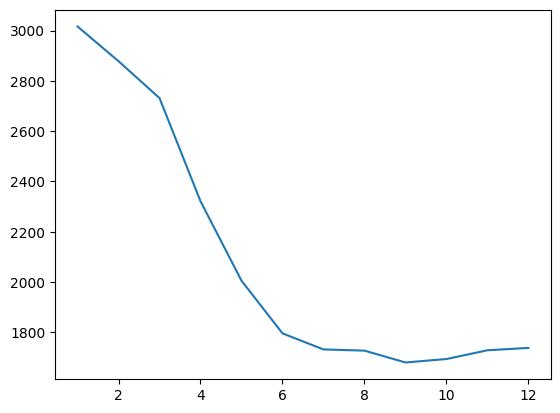

In [85]:
import matplotlib.pyplot as plt

label_rank_list = [r["mean_label_rank"] for r in result_metrics]
epoch_list = [r["epoch"] for r in result_metrics]

plt.plot(epoch_list, label_rank_list)